In [22]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np 
import glob as glob
import random
from statistics import mode
from numpy import trapz
from astropy.time import Time

In [23]:
def gsmooth(x_array, y_array, var_y, vexp = .001, nsig = 5.0):
    #returns smoothed flux array
    # if no variance array create a constant one
    if len(var_y) == 0:
        var_y = np.zeros(len(y_array))
        
    for i in range(len(var_y)):
        if var_y[i] == 0:
            var_y[i] = 1E-20
            # var_y[i] = 1E-31
    
    # Output y-array
    new_y = np.zeros(len(x_array), float)
    
    # Loop over y-array elements
    for i in range(len(x_array)):
        
        # Construct a Gaussian of sigma = vexp*x_array[i]
        gaussian = np.zeros(len(x_array), float)
        sigma = vexp*x_array[i]
        
        # Restrict range to +/- nsig sigma
        sigrange = np.nonzero(abs(x_array-x_array[i]) <= nsig*sigma)
        gaussian[sigrange] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x_array[sigrange]-x_array[i])/sigma)**2)
        
        # Multiply Gaussian by 1 / variance
        W_lambda = gaussian / var_y
        
        # Perform a weighted sum to give smoothed y value at x_array[i]
        W0 = np.sum(W_lambda)
        W1 = np.sum(W_lambda*y_array)
        new_y[i] = W1/W0

    # Return smoothed y-array
    return new_y

In [24]:
def deredshift(wavelength, z):
    dered_wave = wavelength / (1+z)
    return dered_wave

In [25]:
def find_min_wave(dered_wave, sm_flux, w1 = 5900., w2 = 6500.):
    elem_range = np.where((dered_wave > w1) & (dered_wave < w2)) #set domain as within minwave and maxwave
    list(elem_range)
    elem_wavelist = dered_wave[elem_range] 
    elem_fluxlist = sm_flux[elem_range] #find corresponding flux vales for wavelengths within domain
    elem_flux = min(elem_fluxlist) #find minimum value within these flux vales to locate "dip"
    elem_wavelength = dered_wave[np.where(sm_flux == elem_flux)][0] #find the corresponding wavelength
    return(elem_wavelength)

In [26]:
def find_equivalent_width(dered_wave, sm_flux, w1 = 5700., w2 = 6100., w3 = 6300., w4 = 6550.):
    max_1 = np.where((dered_wave > w1) & (dered_wave < w2))
    list(max_1)
    elem_wavelist_1 = dered_wave[max_1]
    elem_fluxlist_1 = sm_flux[max_1]
    elem_flux_1 = max(elem_fluxlist_1)
    max_1_wave = dered_wave[np.where(sm_flux == elem_flux_1)][0]
    
    max_2 = np.where((dered_wave > w3) & (dered_wave < w4))
    list(max_2)
    elem_wavelist_2 = dered_wave[max_2]
    elem_fluxlist_2 = sm_flux[max_2]
    elem_flux_2 = max(elem_fluxlist_2)
    max_2_wave = dered_wave[np.where(sm_flux == elem_flux_2)][0]
    
    eqw_domain = np.where((dered_wave >= max_1_wave) & (dered_wave <= max_2_wave))
    list(eqw_domain)
    elem_fluxlist_eqw_domain = sm_flux[eqw_domain]
    elem_wavelist_eqw_domain = dered_wave[eqw_domain]
    
    m = ((elem_flux_2 - elem_flux_1)/(max_2_wave - max_1_wave))
    b = elem_flux_2 - m*(max_2_wave)
    y = m*(elem_wavelist_eqw_domain) + b
    
    area_small = trapz(elem_fluxlist_eqw_domain, dx=1)
    area_big = trapz(y, dx =1)
    
    equivalent_width = area_big - area_small
    
    return (equivalent_width)

In [27]:
eq_width = find_equivalent_width(dered_wave, sm_flux)
print(eq_width)

2.30978589989e-14


In [29]:
def find_velocity(min_wave, rest_wave = 6355.):
    wavelength_prop = min_wave / rest_wave
    ejecta_velocity = c * (wavelength_prop ** 2 - 1) / (wavelength_prop ** 2 + 1)
    return ejecta_velocity

In [30]:
def get_SN_name(file):
    SN_name = file.split('-')[0]
    return SN_name

In [32]:
def make_z_dict(file):
    #reads in CfA4_info.txt
    sn_datatext = open(file, "r")
    sn_datainfo = sn_datatext.readlines()
    z_dict = {}
    start_line = 60
    for line in sn_datainfo[start_line:]:
        line_elems = line.split()
        temp = line_elems[0]
        if temp[0] == "2":
            name = "sn" + temp
        else:
            name = temp
        z = line_elems[10]
        z_dict[name] = float(z)
    return z_dict

In [33]:
def vel_error_dist(wavelength, flux, flux_error, n = 1000):
    velocity_distribution = []
    minwave = 6000
    maxwave = 7000
    wavelength_rest = 6355
    for i in range(n):
        vexp= np.random.normal(.0015,.00025) 
        smooth_flux = gsmooth(wavelength, flux, flux_error,vexp)
        SiII_obs = find_wave_obs(wavelength, smooth_flux, minwave, maxwave)
        v = find_velocity(SiII_obs, wavelength_rest)
        #print (v, vexp, SiII_obs) this line can be uncommented to analyze increments of the loop individually
        velocity_distribution.append(v)
    vmode = mode(velocity_distribution)
    vmean = np.mean(velocity_distribution)
    vstd = np.std(velocity_distribution)
    plt.hist(velocity_distribution)
    return "Ejecta velocity is", vmode ,"km/s", "mean velocity is", vmean, "km/s", "standard deviation is", vstd, "km/s"

In [34]:
'''
for i in range (1000):
        dist = vel_error_dist(dered_wavelength, flux, flux_error, n = 1000)
        mean = np.mean(dist)
        mean_dist.append(mean)
    mean_dist_order = sorted(mean_dist)
    lower95 = mean_dist_order[24]
    upper95 = mean_dist_order[974]
    return lower95, upper95
'''

'\nfor i in range (1000):\n        dist = vel_error_dist(dered_wavelength, flux, flux_error, n = 1000)\n        mean = np.mean(dist)\n        mean_dist.append(mean)\n    mean_dist_order = sorted(mean_dist)\n    lower95 = mean_dist_order[24]\n    upper95 = mean_dist_order[974]\n    return lower95, upper95\n'

In [1]:
def dflux(wave):
    unsmflux = flux[np.where(dered_wavelength == wave)]
    smflux = sm_flux[np.where(dered_wavelength == wave)]
    dflux = smflux - unsmflux
    return dflux

In [35]:
#Parse ned for associated galaxy
#use astroquery to find z value
def find_z(SN_name):
    query_url = 'https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=sn2007fs&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES'
    sn_url = query_url.replace("sn2007fs", SN_name)
    return sn_url

In [36]:
def plotspectra(wavelength, flux, dered_wave, sm_flux):
    plt.figure(figsize=(20, 10))
    plt.axvline(x=6355, linewidth=.5)
    #resting wavelength of Si II
    plt.plot(wavelength, flux, linewidth=1, color='red') #redshifted
    plt.plot(dered_wave, sm_flux, linewidth=1, color='blue') #deredshifted
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Relative Flux')

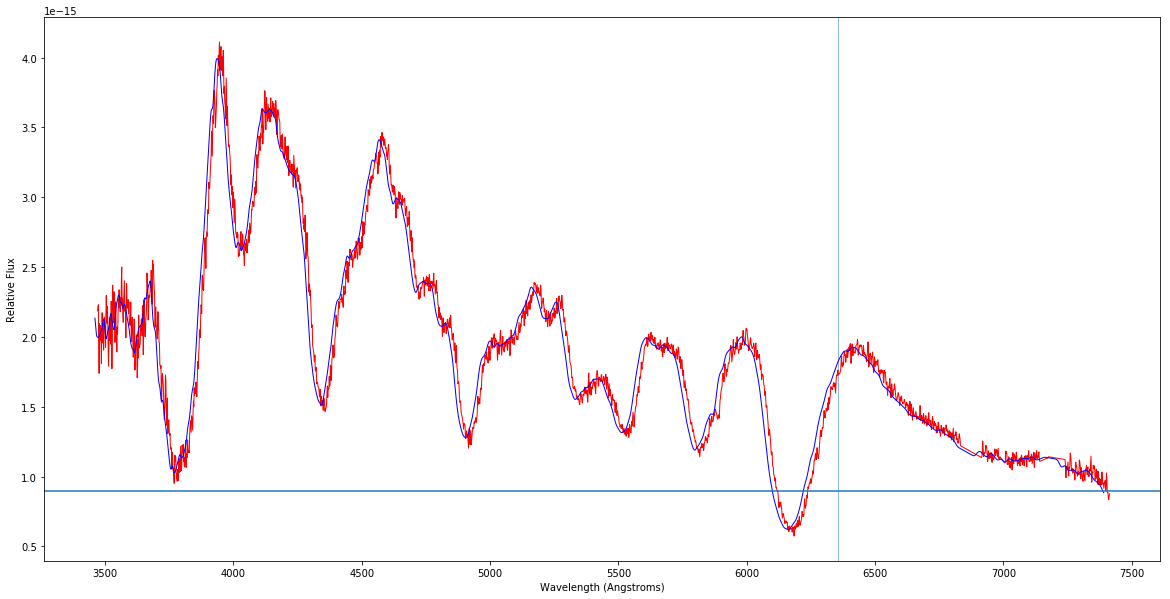

In [37]:
#TEST YOUR CODE ON ONE OBJECT (plot original spectrum, deredshifted spectrum, and the smoothed deredshifted spectrum, print velocity)
#YOUR CODE GOES HERE
my_Supernova = ("sn2007hj-20070903.28-fast.flm")

wavelength, flux, flux_error = np.loadtxt(my_Supernova, unpack = True)
z = 0.003
dered_wave = deredshift(wavelength, z)
sm_flux = gsmooth(dered_wave, flux, flux_error)

plotspectra(wavelength, flux, dered_wave, sm_flux)

plt.axhline(y = 9e-16)


In [38]:
#YOUR CODE GOES HERE
z_dict = make_z_dict("CfA4_info.txt")
sndata = glob.glob("*.flm")
wavelength, flux, flux_error = np.loadtxt(sndata[0], unpack = True)
z = 0.017192 #obtain from NED
c = 299792 #speed of light in km/s
print(sndata)
dered_wave = deredshift(wavelength, z)
sm_flux = gsmooth(dered_wave, flux, flux_error)
min_wave = find_min_wave(dered_wave, sm_flux)
print(min_wave)
v = find_velocity(min_wave)
print(v)

['sn2007hj-20070903.28-fast.flm', 'sn2007A-20070109.12-fast.flm', 'sn2007fb-20070707.44-fast.flm', 'sn2007fs-20070718.42-fast.flm', 'sn2007jg-20070920.46-fast.flm']
6077.20076446
-13391.1006786


In [39]:
make_z_dict("CfA4_info.txt")

{'PTF10bjs': 0.03,
 'sn2006ct': 0.0315,
 'sn2006ou': 0.0135,
 'sn2007A': 0.0177,
 'sn2007aj': 0.011,
 'sn2007bj': 0.0167,
 'sn2007cb': 0.0366,
 'sn2007cc': 0.0291,
 'sn2007cf': 0.0329,
 'sn2007cn': 0.0253,
 'sn2007cs': 0.0176,
 'sn2007ev': 0.0427,
 'sn2007fb': 0.018,
 'sn2007fq': 0.0425,
 'sn2007fs': 0.0172,
 'sn2007hg': 0.03,
 'sn2007hj': 0.0141,
 'sn2007hu': 0.0354,
 'sn2007if': 0.0742,
 'sn2007ir': 0.0352,
 'sn2007is': 0.0297,
 'sn2007jg': 0.0371,
 'sn2007kd': 0.0242,
 'sn2007kf': 0.046,
 'sn2007kg': 0.007,
 'sn2007kh': 0.05,
 'sn2007kk': 0.041,
 'sn2007le': 0.0067,
 'sn2007nq': 0.045,
 'sn2007ob': 0.0339,
 'sn2007rx': 0.0301,
 'sn2007ss': 0.0155,
 'sn2007su': 0.0279,
 'sn2007sw': 0.0252,
 'sn2007ux': 0.0309,
 'sn2008A': 0.0165,
 'sn2008C': 0.0166,
 'sn2008Q': 0.06,
 'sn2008Y': 0.0697,
 'sn2008Z': 0.021,
 'sn2008ac': 0.0528,
 'sn2008ad': 0.05,
 'sn2008ae': 0.0301,
 'sn2008ai': 0.0353,
 'sn2008ar': 0.0261,
 'sn2008at': 0.035,
 'sn2008bi': 0.0134,
 'sn2008bw': 0.0331,
 'sn2008by': 0.0

In [2]:
class Supernova:
    def __init__(SN_name):
        SN_name.name = SN_name
        SN_name.files = glob.glob(SN_name)
        SN_name.data = wavelength, flux, flux_error = np.loadtxt(SN_name.files[0], unpack = True)

In [41]:
#FINAL SCRIPT STEPS
#1) Get array of all flm file names
#2) Make redshift dictionary
#3) loop through files
    #a) read in spectrum
    #b) get SN name from file name
    #c) get redshift from dictionary
    #d) deredshift
    #e) smooth
    #f) find wavelength where Si line is minimum
    #g) find and print velocity (and SN name)

In [42]:
sndata = glob.glob("*.flm")

z_dict = make_z_dict("CfA4_info.txt")
for i in range(len(sndata)):
    name = get_SN_name(sndata[i])
    wavelength, flux, flux_error = np.loadtxt(sndata[i], unpack = True)
    dered_wave = deredshift(wavelength, z_dict[name])
    sm_flux = gsmooth(dered_wave, flux, flux_error)
    min_wave = find_min_wave(dered_wave, sm_flux)
    v = find_velocity(min_wave)
    print (v)

-12480.1227903
-10611.0637019
-11752.8635862
-10839.2331491
-12759.6282317


In [43]:
def find_t_obs(file): #gets observed date and time from file name and converts it to a modified julian date
    date = file.split('-')[1]
    datetime = date[0:4] + "-" + date[4:6] + "-" + date[6:]
    t = Time(datetime)
    t.format = 'mjd'    
    t_obs = t.value
    return t_obs
    
#test it out
find_t_obs("sn2007jg-20070920.46-fast.flm")

54363.00000532407

In [44]:
def measure_phase(file, t_max): #get t_max from Matt
    t_obs = find_t_obs(file)
    z = z_dict[get_SN_name(file)]
    phase = (t_obs - t_max)/(1+z)
    return phase

#random test with random t_max, I don't know what t-max is yet
measure_phase("sn2007jg-20070920.46-fast.flm", 53000)

1314.2416404628993

In [45]:
def find_v_0 (phase, v_obs): #computes velocity at t_max
    v = v_obs
    t = phase
    v_0 = (v + (0.285*t))/(1 - (0.0322*t))
    return v_0